In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
# reference https://github.com/rlabbe/filterpy

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# read CSV file
traj_lens = np.loadtxt('./Trajectory/data/traj_lens.csv')
print(f"number of trajectories = {len(traj_lens)}")

traj_start = np.zeros((len(traj_lens)+1,1), dtype=int)
# traj_end = np.zeros((len(traj_lens),1))
idx = 1
for length in traj_lens[:]:
    traj_start[idx] = traj_start[idx - 1] + length
    # traj_end[idx-1] = traj_start[idx] - 1
    idx = idx + 1

# traj_end[-1] = traj_lens[-1] + traj_end[-2] - 1

original_position_list = np.loadtxt('./Trajectory/data/original_position_list.csv')
position_noise_001 = np.loadtxt('./Trajectory/data/position_noise_0.01.csv')
position_noise_01 = np.loadtxt('./Trajectory/data/position_noise_0.1.csv')
position_noise_1 = np.loadtxt('./Trajectory/data/position_noise_1.csv')

connnected = np.loadtxt('./Trajectory/data/connected_ct_0.1.csv')

print(original_position_list.shape)

number of trajectories = 100
(65900, 3)


trajectory length = 462


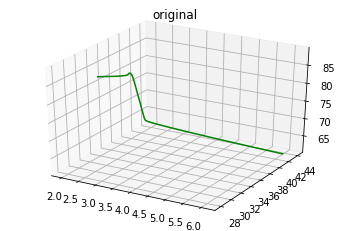

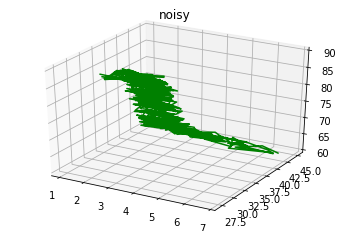

In [3]:
traject_select = 2

original = original_position_list[traj_start[traject_select][0]: traj_start[traject_select+1][0]][:]
noisy = position_noise_01[traj_start[traject_select][0]: traj_start[traject_select+1][0]][:]

def plot_trajectory(x, title):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')

def plot_compare(x1, x2, title, label1, label2):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)

    xline = x1[:,0]
    yline = x1[:,1]
    zline = x1[:,2]
    ax.plot3D(xline, yline, zline, 'red')

    xline = x2[:,0]
    yline = x2[:,1]
    zline = x2[:,2]
    ax.plot3D(xline, yline, zline, 'blue')
    

plot_trajectory(original, "original")
plot_trajectory(noisy, "noisy")

print(f"trajectory length = {noisy.shape[0]}")

In [4]:

def initialise_filter(filter):

    dt = 0.01 # constant sampling time



    # transition matrix
    filter.F = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]]
    )

    # measurement matrix
    filter.H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0]]
    )

    ## tunable parameters

    # covariance matrix
    filter.P *= 1000 


    # measurement noise
    filter.R = np.diag([0.5, 0.5, 0.5])

    # process noise
    filter.Q = np.diag([1e-3,1e-3,1e-3, 1e-2, 1e-2, 1e-2]) #Q_discrete_white_noise(3, dt, .1)



In [5]:
filter = KalmanFilter(dim_x=6, dim_z=3) # internal state has x,y,z,vx,vy,vz

initialise_filter(filter)

# feeding data to kalman filter

# initialise the state
initial_guess = np.concatenate([noisy[0],np.array([0,0,0])])
filter.x = initial_guess

np.set_printoptions(precision=2);

# prediction
filtered = np.zeros((original.shape[0],6))
filtered[0] = initial_guess # no filter available yet
for i in range(original.shape[0]):

    if i == 0:
        print(f"{noisy[i]} and {filter.x}")
        continue

    filter.predict()
    # print(f"{noisy[i]} and {filter.x}")
    error = noisy[i] - filter.x[0:3]
    filter.update(noisy[i])

    filtered[i] = filter.x
    
    
    

    

[ 2.34 28.33 89.62] and [ 2.34 28.33 89.62  0.    0.    0.  ]


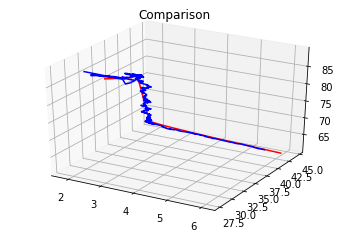

In [6]:
plot_compare(original, filtered[:,0:3],"Comparison","filtered","original")

Non-Linear Least Squre Approach

In [95]:
import scipy.optimize as optimisation
import copy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
# https://python4mpia.github.io/fitting_data/least-squares-fitting.html

def residual(estimated, alpha, data):
    # smoothness constraint by minimising pairwise distance
    estimated = np.reshape(estimated,(-1,3))
    # data = data.flatten()
    # N = estimated.shape[0]
    # print(N)
    # print(data.shape)
    # assert(estimated.shape[0] == data.shape[0] )

    smoothness_loss = np.square(np.diff(estimated, axis=0))
    smoothness_loss = np.append(smoothness_loss,[[0,0,0]], axis=0)
    

    # smoothness_loss = np.sum(smoothness_loss, axis=1, keepdims=1)

    # print(smoothness_loss.shape)
    # print(smoothness_loss)

    data_loss = np.square(estimated - data)
    return (smoothness_loss + alpha * data_loss).flatten()
    

In [97]:
x0 = copy.deepcopy(noisy)
print(x0)
alpha = 0.5
optimisation.leastsq(residual, x0, args=(alpha, noisy))

[[ 2.34 28.33 89.62]
 [ 3.46 28.38 89.38]
 [ 3.8  27.19 88.48]
 ...
 [ 5.05 42.56 60.67]
 [ 5.9  43.99 61.17]
 [ 6.75 42.64 61.31]]


(array([ 2.86, 28.13, 89.38, ...,  6.2 , 43.16, 61.08]), 1)

In [ ]:
x0